In [71]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [72]:
births = spark.read.csv("births.csv", header=True, inferSchema=True)
births.show()

+----------------------+----------+-----------+-----------+----------------+-----------------+----------------+-------------------+----------------+--------------------+----------+---------+---------+---------+----------------+-----------------+-----------------+----------------------+------------------+------------+-------------+------------+-------------+------------------+-------+----------------------+---------+----------+--------+-----------+----------+------------------------+---------------+-------+--------------+--------+---------------+----------+-------------------------+-------------------+-------------------+------------------------+---------------------+----------------+------------------+---------------+-----------------------+----------------+-----------------------+---------------------+--------------------+-------------------------------------+--------------------------------------+----------------+
|INFANT_ALIVE_AT_REPORT|BIRTH_YEAR|BIRTH_MONTH|BIRTH_PLACE|MOTHER_AGE_

C:\Users\Jonathan Maverick\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


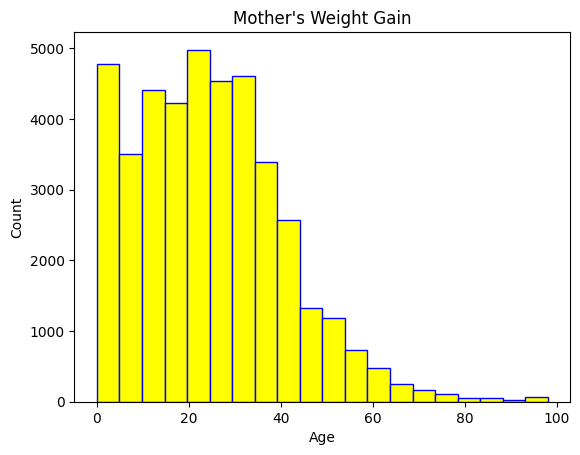

In [73]:
import matplotlib.pyplot as plt

births.registerTempTable("MsBirth")
result = spark.sql("""
    SELECT MOTHER_WEIGHT_GAIN
    FROM MsBirth          
    WHERE MOTHER_WEIGHT_GAIN != 99
""")
resultPandas = result.toPandas()

plt.hist(resultPandas, bins=20, color="yellow", edgecolor="blue")
plt.title("Mother's Weight Gain")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

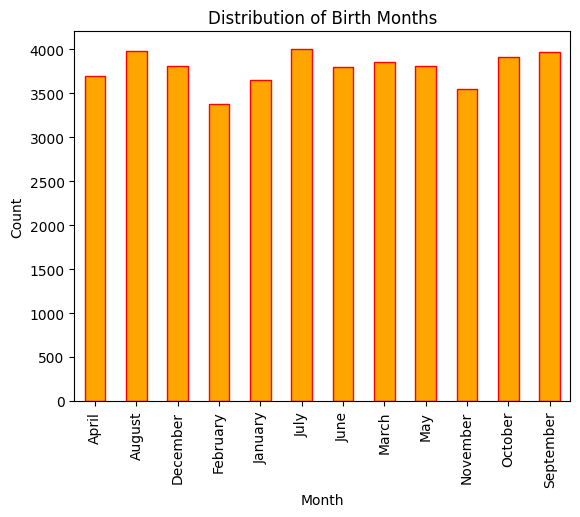

In [74]:
from pyspark.sql.functions import when

birth_month = births.select("BIRTH_MONTH")

birth_month = birth_month.withColumn("BIRTH_MONTH", 
                                     when(birth_month["BIRTH_MONTH"] == 1, "January")
                                    .when(birth_month["BIRTH_MONTH"] == 2, "February")
                                    .when(birth_month["BIRTH_MONTH"] == 3, "March")
                                    .when(birth_month["BIRTH_MONTH"] == 4, "April")
                                    .when(birth_month["BIRTH_MONTH"] == 5, "May")
                                    .when(birth_month["BIRTH_MONTH"] == 6, "June")
                                    .when(birth_month["BIRTH_MONTH"] == 7, "July")
                                    .when(birth_month["BIRTH_MONTH"] == 8, "August")
                                    .when(birth_month["BIRTH_MONTH"] == 9, "September")
                                    .when(birth_month["BIRTH_MONTH"] == 10, "October")
                                    .when(birth_month["BIRTH_MONTH"] == 11, "November")
                                    .when(birth_month["BIRTH_MONTH"] == 12, "December")
                                     .otherwise("Unknown"))
                                     
birth_month_counts = birth_month.toPandas().groupby("BIRTH_MONTH").size()

birth_month_counts.plot(kind="bar", color="orange" , edgecolor="red")
plt.title("Distribution of Birth Months")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

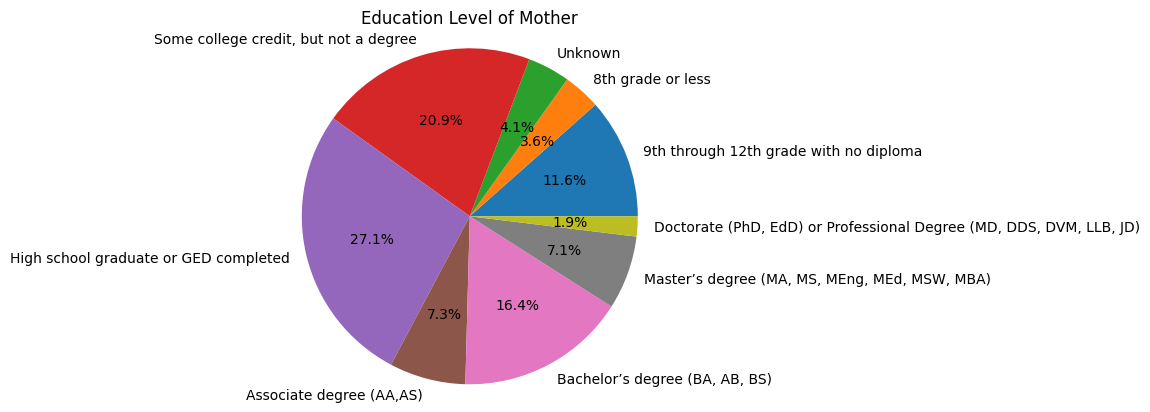

In [75]:
from pyspark.sql.functions import when

mother_education = births.select("MOTHER_EDUCATION")

mother_education = mother_education.withColumn("MOTHER_EDUCATION", 
                                     when(mother_education["MOTHER_EDUCATION"] == 1, "8th grade or less")
                                    .when(mother_education["MOTHER_EDUCATION"] == 2, "9th through 12th grade with no diploma")
                                    .when(mother_education["MOTHER_EDUCATION"] == 3, "High school graduate or GED completed")
                                    .when(mother_education["MOTHER_EDUCATION"] == 4, "Some college credit, but not a degree")
                                    .when(mother_education["MOTHER_EDUCATION"] == 5, "Associate degree (AA,AS)")
                                    .when(mother_education["MOTHER_EDUCATION"] == 6, "Bachelor’s degree (BA, AB, BS)")
                                    .when(mother_education["MOTHER_EDUCATION"] == 7, "Master’s degree (MA, MS, MEng, MEd, MSW, MBA)")
                                    .when(mother_education["MOTHER_EDUCATION"] == 8, "Doctorate (PhD, EdD) or Professional Degree (MD, DDS, DVM, LLB, JD)")
                                    .otherwise("Unknown"))
                                     
education_count = mother_education.groupBy("MOTHER_EDUCATION").count().collect()

labels = [row["MOTHER_EDUCATION"] for row in education_count]
counts = [row["count"] for row in education_count]

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Education Level of Mother")
plt.axis("equal")
plt.show()

## Classification

In [76]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

#Import data
df_test = spark.read.csv("births.csv", header=True, inferSchema=True)
df_train = spark.read.csv("births.csv", header=True, inferSchema=True)

#Select features and data columns
df_test = df_test.select("INFANT_ALIVE_AT_REPORT", "DIABETES_PRE", "INFANT_ANTIBIOTICS", "INFANT_SEIZURES", "INFANT_BREASTFED")
df_train = df_train.select("INFANT_ALIVE_AT_REPORT", "DIABETES_PRE", "INFANT_ANTIBIOTICS", "INFANT_SEIZURES", "INFANT_BREASTFED")

#Filter NA
df_test = df_test.na.drop()
df_train = df_train.na.drop()

#Transform data
df_test = df_test.withColumn("INFANT_ALIVE_AT_REPORT", when(df_test["INFANT_ALIVE_AT_REPORT"] == "Y", 1).otherwise(0))
df_test = df_test.withColumn("INFANT_BREASTFED", when(df_test["INFANT_BREASTFED"] == "Y", 1).otherwise(0))
df_test = df_test.withColumn("INFANT_SEIZURES", when(df_test["INFANT_SEIZURES"] == "Y", 1).otherwise(0))
df_test = df_test.withColumn("INFANT_ANTIBIOTICS", when(df_test["INFANT_ANTIBIOTICS"] == "Y", 1).otherwise(0))
df_test = df_test.withColumn("DIABETES_PRE", when(df_test["DIABETES_PRE"] == "Y", 1).otherwise(0))

df_train = df_train.withColumn("INFANT_ALIVE_AT_REPORT", when(df_train["INFANT_ALIVE_AT_REPORT"] == "Y", 1).otherwise(0))
df_train = df_train.withColumn("INFANT_BREASTFED", when(df_train["INFANT_BREASTFED"] == "Y", 1).otherwise(0))
df_train = df_train.withColumn("INFANT_SEIZURES", when(df_train["INFANT_SEIZURES"] == "Y", 1).otherwise(0))
df_train = df_train.withColumn("INFANT_ANTIBIOTICS", when(df_train["INFANT_ANTIBIOTICS"] == "Y", 1).otherwise(0))
df_train = df_train.withColumn("DIABETES_PRE", when(df_train["DIABETES_PRE"] == "Y", 1).otherwise(0))

#Normalize data
cols = df_train.columns
cols.remove("INFANT_ALIVE_AT_REPORT")

df_train = VectorAssembler(inputCols=cols, outputCol="VectorOut").transform(df_train)
df_train = StandardScaler(inputCol="VectorOut", outputCol="features").fit(df_train).transform(df_train)

df_test = VectorAssembler(inputCols=cols, outputCol="VectorOut").transform(df_test)
df_test = StandardScaler(inputCol="VectorOut", outputCol="features").fit(df_test).transform(df_test)

model = LogisticRegression(featuresCol="features", labelCol="INFANT_ALIVE_AT_REPORT", maxIter=100).fit(df_train)

predictResult = model.transform(df_test)

evaluator = BinaryClassificationEvaluator(labelCol="INFANT_ALIVE_AT_REPORT")
print(f"Accuracy : {evaluator.evaluate(predictResult)*100}%")

Accuracy : 81.94442630832961%
